<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_Identification_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Téléchargement des données

In [11]:
!rm *.csv
!rm *.zip
!wget --no-check-certificate --content-disposition "https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip?raw=true"
!unzip Bitcoin_complet.zip
!wget --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/RandomForest/toys.csv"

--2021-05-01 19:13:42--  https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip [following]
--2021-05-01 19:13:42--  https://github.com/AlexandreBourrieau/ML/raw/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin/Bitcoin_complet.zip [following]
--2021-05-01 19:13:42--  https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/

In [12]:
df_data=pd.read_csv('Bitcoin_complet.csv')
df_data.shape

(2309, 780)

In [13]:
df_data.head()

,Dates,#Active_Adresses,Block Size,Block Time,FeeInReward,Price,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,2015-01-01,114998.0,187402.0,8.727,0.195,315.626,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,129854868.0,21.241,18681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,184462.0,265055.0,8.727,0.286,314.346,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,212156964.0,21.197,9385.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,216194.0,295066.0,8.889,0.291,303.591,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,235281521.0,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,209509.0,282161.0,8.372,0.504,274.820,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e+10,85522.0,3.586,271649082.0,21.157,7300.0,203388.333333,280760.666667,8.662667,0.360333,297.585667,0.053500,3192.000000,140320.000000,8.209000,3.317068e+17,4.037611e+09,0.029767,108.839667,4.064096e+10,82236.333333,3.739667,2.396959e+08,21.160333,8342.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,208147.0,360878.0,9.231,0.412,272.076,0.0459,3222.0,161359.0,9.439,3.350929e+17,3.705753e+09,0.0272,90.598,4.064096e+10,95429.0,3.180,283038295.0,21.155,23092.0,211283.333333,312701.666667,8.830667,0.402333,283.495667,0.053133,3306.666667,148994.000000,8.813667,3.333361e+17,3.848725e+09,0.028367,97.407333,4.064096e+10,87672.000000,3.487000,2.633230e+08,21.146333,12911.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_toys = pd.read_csv('toys.csv')
df_toys

,Unnamed: 0,x.V1,x.V2,x.V3,x.V4,x.V5,x.V6,x.V7,x.V8,x.V9,x.V10,x.V11,x.V12,x.V13,x.V14,x.V15,x.V16,x.V17,x.V18,x.V19,x.V20,x.V21,x.V22,x.V23,x.V24,x.V25,x.V26,x.V27,x.V28,x.V29,x.V30,x.V31,x.V32,x.V33,x.V34,x.V35,x.V36,x.V37,x.V38,x.V39,...,x.V162,x.V163,x.V164,x.V165,x.V166,x.V167,x.V168,x.V169,x.V170,x.V171,x.V172,x.V173,x.V174,x.V175,x.V176,x.V177,x.V178,x.V179,x.V180,x.V181,x.V182,x.V183,x.V184,x.V185,x.V186,x.V187,x.V188,x.V189,x.V190,x.V191,x.V192,x.V193,x.V194,x.V195,x.V196,x.V197,x.V198,x.V199,x.V200,y
0,1,-0.296743,-1.617985,-1.067409,-0.444225,-0.523051,-0.387087,-0.152861,-0.813153,1.821314,0.459206,-0.223613,1.097568,-0.850850,-0.785266,0.132274,0.482038,-1.983613,0.942889,2.596865,-0.343049,-0.380011,-2.380398,1.085157,-0.888244,-0.871203,0.633793,1.800543,0.760820,-1.638289,0.441141,1.710350,0.853786,0.200819,-0.006223,-0.951282,0.937988,-0.381694,2.425591,-0.078469,...,-0.251172,1.906951,0.384631,0.329516,1.260098,-0.129725,-1.011991,0.277233,-1.415776,1.198413,1.153426,0.725026,0.829842,0.039747,0.385574,-1.472286,-0.603823,-1.730519,0.379732,1.693862,0.780711,0.912187,1.767525,-0.430677,0.071865,1.080474,0.701343,0.064456,-0.619621,0.924595,0.370300,0.398044,-0.160588,0.043154,1.572425,0.800887,-0.990729,0.651969,0.068696,-1
1,2,0.486371,-1.226510,-1.143179,-0.636657,0.850600,-0.455772,-0.351081,-0.017519,1.347124,-1.109948,-0.445812,-0.554439,-0.311195,1.017659,0.449656,-0.361936,-0.085926,-0.504657,1.137268,1.083371,1.784430,-0.167004,2.085521,0.662175,-0.104739,0.200151,-0.839331,0.958518,-1.171351,-0.365596,0.186393,1.090350,-1.344049,-2.014388,0.410700,0.238906,1.334687,1.196768,-1.919587,...,-0.262593,0.105936,-1.200648,1.727008,-0.133634,-0.917945,-0.864354,-0.078567,0.722163,-0.676553,0.355075,1.080515,-0.124409,1.374917,0.497287,1.200954,2.012601,0.029440,0.062998,0.172547,0.598270,-2.177544,0.692202,0.744225,1.866060,-1.507063,-0.147119,-0.527542,-0.591152,-0.621535,0.573124,-2.377734,0.336318,-0.949745,-0.735897,0.585292,0.706542,-0.368315,-0.240767,-1
2,3,0.535142,1.355318,1.375397,-0.579428,1.305002,0.099686,0.361779,-2.053743,0.583147,0.421121,-0.932565,-0.900546,1.474189,0.156475,-0.746168,-0.847667,-0.168099,-1.486241,1.416818,-1.357959,-0.395958,-1.660047,-0.930309,-1.793992,-0.283678,-0.656871,-0.787498,1.411877,1.458813,-0.258919,0.494500,1.244011,0.301916,1.654792,1.317463,-0.327037,-0.250719,-0.527441,1.293183,...,-0.069306,0.296328,0.291794,1.284333,1.587168,-2.216640,0.783389,-0.414295,0.759765,-0.943134,-1.754285,0.830438,-0.479191,0.930959,1.290842,-0.244302,-1.018051,0.238724,1.090003,1.135828,-2.653731,-0.838220,0.145952,0.628750,-1.511405,1.124491,-0.027473,0.108547,1.158716,0.089219,0.421149,0.208149,2.192439,1.302854,-0.812417,0.341327,1.008698,-0.166779,-0.543828,1
3,4,-1.108412,-0.511105,-1.021268,-0.236729,-0.039741,-0.508630,0.626754,-1.702281,-0.461578,0.580026,0.321564,1.502270,2.123768,1.062642,-1.238982,-0.995330,0.193948,0.191298,-0.868633,-0.883037,-0.486731,1.184768,1.664748,1.869663,0.293137,-1.948130,-0.692916,-1.742261,2.654250,-0.497093,1.045789,1.584237,-0.416216,0.698336,1.553863,-0.614909,0.973363,1.120632,1.162803,...,-0.318418,0.836738,-0.046846,-0.736397,0.559300,0.540311,2.575727,-0.505777,-0.475962,0.083937,0.832040,0.439538,-0.225770,0.135025,0.705082,-0.774655,-0.264935,-0.338405,-0.161711,-0.574960,1.065603,-0.390303,-0.254957,0.935546,-0.921236,-1.351187,-0.754118,2.043094,-0.332596,1.696144,-0.003792,0.935080,-0.949002,-0.454278,0.014389,0.273597,0.522809,0.297845,-0.666710,-1
4,5,1.861425,0.769617,1.244290,0.584073,-0.496416,-1.205467,-1.347270,-0.231697,-0.345950,0.693925,-0.028164,0.438850,0.343773,-0.595585,0.434864,-0.588576,-0.684969,0.086054,0.009321,0.303367,0.572145,1.127946,0.513860,0.723561,0.867375,0.437553,-0.642393,-0.853743,-0.591145,-0.491037,1.374240,-0.869190,-0.122077,0.833898,0.203234,-1.635720,0.929811,0.042271,-0.688628,...,-0.930594,-0.218552,0.006319,-2.138181,-0.306294,0.753748,-1.230530,1.121701,-1.289204,-0.574936,-0.144443,-0

# Préparation des jeux de données

In [15]:
# Déplace la colonne Prix au début
col_prix = df_data.pop('Price')
df_data.insert(1,'Price',col_prix)
df_data.head()

,Dates,Price,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,2015-01-01,315.626,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,129854868.0,21.241,18681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02,314.346,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,212156964.0,21.197,9385.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-03,303.591,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,235281521.0,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-04,274.820,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e+10,85522.0,3.586,271649082.0,21.157,7300.0,203388.333333,280760.666667,8.662667,0.360333,297.585667,0.053500,3192.000000,140320.000000,8.209000,3.317068e+17,4.037611e+09,0.029767,108.839667,4.064096e+10,82236.333333,3.739667,2.396959e+08,21.160333,8342.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,272.076,208147.0,360878.0,9.231,0.412,0.0459,3222.0,161359.0,9.439,3.350929e+17,3.705753e+09,0.0272,90.598,4.064096e+10,95429.0,3.180,283038295.0,21.155,23092.0,211283.333333,312701.666667,8.830667,0.402333,283.495667,0.053133,3306.666667,148994.000000,8.813667,3.333361e+17,3.848725e+09,0.028367,97.407333,4.064096e+10,87672.000000,3.487000,2.633230e+08,21.146333,12911.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
X_raw = df_data.iloc[:,2:20]
X_raw.head()

,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets
0,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,129854868.0,21.241,18681.0
1,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,212156964.0,21.197,9385.0
2,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,235281521.0,21.127,8342.5
3,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e+10,85522.0,3.586,271649082.0,21.157,7300.0
4,208147.0,360878.0,9.231,0.412,0.0459,3222.0,161359.0,9.439,3.350929e+17,3.705753e+09,0.0272,90.598,4.064096e+10,95429.0,3.180,283038295.0,21.155,23092.0


In [17]:
X = df_data
X = X.drop(columns=['Price','Dates'])
Xdrop = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(X)
Xdrop = pd.DataFrame(Xdrop)
Xdrop.columns =X.columns
X = Xdrop
X

,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,Block Size_sma7,Block Time_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,1.298549e+08,21.241,18681.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
1,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,2.121570e+08,21.197,9385.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
2,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,2.352815e+08,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
3,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e

In [18]:
y = df_data.iloc[:,1:2]
y

,Price
0,315.626
1,314.346
2,303.591
3,274.820
4,272.076
...,...
2304,49891.000
2305,50077.000
2306,49657.000
2307,53000.000


In [19]:
X

,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,Block Size_sma7,Block Time_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,1.298549e+08,21.241,18681.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
1,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,2.121570e+08,21.197,9385.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
2,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,2.352815e+08,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
3,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e

In [20]:
X.to_csv("Bitcoin_X.csv")
y.to_csv("Bitcoin_Y.csv")

# Identification des variables par Random Forest : Choix des paramètres

**1. Construction du dataframe sur 1 jour**

In [9]:
X = df_data
X = X.drop(columns=['Price','Dates'])
Xdrop = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(X)
Xdrop = pd.DataFrame(Xdrop)
Xdrop.columns =X.columns
X = Xdrop
X

,#Active_Adresses,Block Size,Block Time,FeeInReward,Transaction Fee,Transaction Value,#From_Adresses,Google GTrends,Hashrate,Capitalization,Median Transaction Fee,Median Transaction Value,Difficulty,#Transactions,Profiltability,Sent,Top100,Tweets,#Active_Adresses_sma3,Block Size_sma3,Block Time_sma3,FeeInReward_sma3,Price_sma3,Transaction Fee_sma3,Transaction Value_sma3,#From_Adresses_sma3,Google GTrends_sma3,Hashrate_sma3,Capitalization_sma3,Median Transaction Fee_sma3,Median Transaction Value_sma3,Difficulty_sma3,#Transactions_sma3,Profiltability_sma3,Sent_sma3,Top100_sma3,Tweets_sma3,#Active_Adresses_sma7,Block Size_sma7,Block Time_sma7,...,Top100_roc14,Tweets_roc14,#Active_Adresses_roc30,Block Size_roc30,Block Time_roc30,FeeInReward_roc30,Price_roc30,Transaction Fee_roc30,Transaction Value_roc30,#From_Adresses_roc30,Google GTrends_roc30,Hashrate_roc30,Capitalization_roc30,Median Transaction Fee_roc30,Median Transaction Value_roc30,Difficulty_roc30,#Transactions_roc30,Profiltability_roc30,Sent_roc30,Top100_roc30,Tweets_roc30,#Active_Adresses_roc90,Block Size_roc90,Block Time_roc90,FeeInReward_roc90,Price_roc90,Transaction Fee_roc90,Transaction Value_roc90,#From_Adresses_roc90,Google GTrends_roc90,Hashrate_roc90,Capitalization_roc90,Median Transaction Fee_roc90,Median Transaction Value_roc90,Difficulty_roc90,#Transactions_roc90,Profiltability_roc90,Sent_roc90,Top100_roc90,Tweets_roc90
0,114998.0,187402.0,8.727,0.195,0.0430,2500.0,93422.0,6.703,3.221646e+17,4.287908e+09,0.0316,78.474,4.064096e+10,59179.0,4.049,1.298549e+08,21.241,18681.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
1,184462.0,265055.0,8.727,0.286,0.0470,2878.0,135337.0,7.625,3.302051e+17,4.272409e+09,0.0314,124.895,4.064096e+10,79122.0,3.938,2.121570e+08,21.197,9385.0,568638.333333,718313.666667,8.996667,0.399333,999.189333,0.069233,1989.666667,320173.000000,6.595667,2.738239e+17,2.759515e+09,0.023700,21.981233,6.653303e+12,314527.000000,0.134333,1.233088e+08,15.635000,23921.333333,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
2,216194.0,295066.0,8.889,0.291,0.0436,3052.0,143066.0,7.736,3.337177e+17,4.078336e+09,0.0304,97.849,4.064096e+10,82065.0,3.695,2.352815e+08,21.127,8342.5,171884.666667,249174.333333,8.781000,0.257333,311.187667,0.044533,2810.000000,123941.666667,7.354667,3.286958e+17,4.212884e+09,0.031133,100.406000,4.064096e+10,73455.333333,3.894000,1.924311e+08,21.188333,12136.166667,184621.857143,971614.285714,9.064429,...,0.000000,-71.291596,-72.362626,-59.963023,0.000000,6.224490,-59.050977,0.000000,-96.787660,-57.313957,0.000000,-38.979472,-58.897265,0.000000,-99.917607,-7.372408,-54.163214,0.000000,-94.052223,0.000000,-73.196680,-70.386909,-62.128476,0.000000,-96.513536,100.000000,0.000000,-97.053662,-65.233857,-20.671771,-38.509627,-59.822936,0.000000,-99.889587,84.855708,-61.829769,0.000000,-96.781896,0.000000,-80.675444
3,209509.0,282161.0,8.372,0.504,0.0699,3646.0,142557.0,9.266,3.311977e+17,3.762088e+09,0.0275,103.775,4.064096e

**2. Choix du nombre d'arbres :**

In [11]:
# Informations sur les données
n = 2309              # Nombre d'observations
p = 778               # Nombre de variables

n_arbres_max = 25

n_arbres = np.linspace(1,n_arbres_max,10).astype(np.int32)
mtry = np.sqrt(p).astype(np.int32)
OOB_err = []

for i in n_arbres:
  print("#Arbres : %d" %i)
  clf = RandomForestRegressor(n_estimators=i, bootstrap=True, oob_score=True, max_samples = n, max_features = mtry, n_jobs=-1)
  clf.fit(X,tf.squeeze(np.asarray(y),1))
  OOB_err.append(1 - clf.oob_score_)

#Arbres : 1


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 3
#Arbres : 6


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 9


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 11


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 14


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 17


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


#Arbres : 19
#Arbres : 22
#Arbres : 25


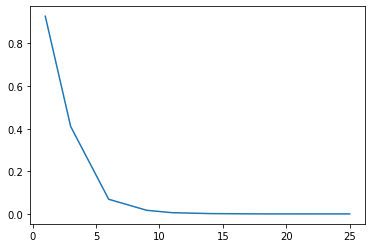

In [12]:
plt.plot(n_arbres,OOB_err)

On choisit n_arbres = 25

**3. Choix de la valeur de mtry (nombre de variables testées à chaque division)**

In [ ]:
(np.sqrt(p)/2).astype(np.int32)

In [ ]:
# Informations sur les données
n = 2309              # Nombre d'observations
p = 778               # Nombre de variables

n_arbres = 25
mtry_0 = (np.sqrt(p)/2).astype(np.int32)

m_try = np.linspace(mtry_0,778,10).astype(np.int32)

OOB_err = []

for i in m_try:
   print("mtry = %s" %i)
   clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=i, n_jobs=-1)
   clf.fit(X,tf.squeeze(np.asarray(y),1))
   OOB_err.append(1 - clf.oob_score_)

In [ ]:
plt.plot(m_try,OOB_err)

On choisit mtry = 768

# Importance des variables - Pemière approche : Importance sans permutations

**1. Entrainement de la forêt**

In [ ]:
from sklearn.inspection import permutation_importance

# Informations sur les données
n = 102               # Nombre d'observations
p = 6033              # Nombre de variables
n_arbres = 25
m_try = 768

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
clf.fit(X,tf.squeeze(np.asarray(y),1))

**2. Affichage de l'importance des variables**

In [ ]:
col_sorted_by_importance=clf.feature_importances_.argsort()
feat_imp = pd.DataFrame({'cols':X.columns[col_sorted_by_importance],'imps':clf.feature_importances_[col_sorted_by_importance]})
feat_imp

In [ ]:
!pip install plotly_express --upgrade -q

In [ ]:
import plotly_express as px
import plotly.offline as po

px.bar(feat_imp.sort_values(['imps'], ascending=False)[:30], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

# Importance des variables - Deuxième approche : Méthode par permutations des importances

Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [ ]:
import random

def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
#    baseline_metric=metric(y, clf.predict(X))
    baseline_metric=clf.score(X,y)
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
#            score=metric(y, clf.predict(X1))
            score = clf.score(X1,y)
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import progressbar

baseline, scores = PermImportance(X, tf.squeeze(np.asarray(y),1), clf, recall_score, num_iterations=10)

In [ ]:
percent_changes={c:[] for c in X.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [ ]:
pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:25]

In [ ]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:25], 
    x='variable',y='value',labels={'variable':'column','value':'% change in recall'})

# Comparaison entre les deux méthodes

In [ ]:
# Calcul des écarts-types et des moyennes
scores_std = {}
scores_mean = {}
for element in scores:
  scores_std[element] = np.std(scores[element])
  scores_mean[element] = np.mean(scores[element])

df_perm = pd.DataFrame.from_dict([scores_std, scores_mean]).transpose()
df_perm = df_perm.rename(columns={0:"std",1:"mean"})
df_perm = df_perm.sort_values(by=['mean'],ascending=False)
df_perm

In [ ]:
feature_perm = df_perm[0:30]
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp[0:30]

tree_indices = np.arange(0, len(feature_imp)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,feature_imp['imps'].values, height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_imp['cols'].values)
ax1.set_ylim((0, len(feature_imp)))

ax2.boxplot(feature_perm, vert=False,labels=feature_perm.index.values)
fig.tight_layout()
plt.show()

# Sélection des variables à partir des méthodes précédentes

**1. Elimination préliminaire dans les résultats de la première méthode**

In [ ]:
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp.reset_index()
feature_imp


In [ ]:
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp.reset_index()
feature_imp = feature_imp[0:100]
feature_imp = feature_imp.reset_index()

plt.plot(feature_imp.index.values,feature_imp['imps'])

In [ ]:
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp.reset_index()
feature_imp = feature_imp[0:30]
feature_imp = feature_imp.reset_index()

plt.plot(feature_imp.index.values,feature_imp['imps'])

On retient les 30 premières variables

**2. Elimination préliminaire dans les résultats de la deuxième méthode**

On commence par rechercher le minimum où la courbe se stabilise :

In [ ]:
feature_perm = df_perm.sort_values(['mean'],ascending=False)
feature_perm = feature_perm.reset_index()
feature_perm = feature_perm[0:8]
feature_perm = feature_perm.reset_index()

plt.plot(feature_perm.index.values,feature_perm['mean'])

On affiche maintenant l'écart type de chaque variable :

In [ ]:
feature_perm = df_perm.sort_values(['mean'],ascending=False)
feature_perm = feature_perm.reset_index()
feature_perm = feature_perm[0:8]
feature_perm = feature_perm.reset_index()

plt.plot(feature_perm.index.values,feature_perm['std'])

On fit cette courbe avec un modèle CART (Classification and Regression Trees) :

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(criterion="mse")
regr.fit(np.reshape(np.array(feature_perm.index.values),(-1,1)),feature_perm['std'].values)
y_reg = regr.predict(np.reshape(np.array(feature_perm.index.values),(-1,1)))

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(go.Scatter(x=feature_perm.index.values,y=feature_perm['std'],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=feature_perm.index.values,y=y_reg,line=dict(color='red', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

In [ ]:
index = []

for i in feature_perm.index.values.astype(np.int32):
  if feature_perm['std'].values[i] >= y_reg[i]:
    index.append(i)

In [ ]:
index

In [ ]:
variables_selected = feature_perm.iloc[index]
variables_selected = variables_selected.drop(columns='level_0')
variables_selected['index'].values

**Fusion des valeurs**

In [ ]:
df_reduit1 = X[feature_imp['cols'].values]
df_reduit1

In [ ]:
df_reduit2 = X[variables_selected['index'].values]
df_reduit2

In [ ]:
df_merged=df_reduit2.merge(df_reduit1,how='outer')
df_merged

**Elimination des variables corrélées**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df

In [ ]:
variables_selected_reduit = drop_high_vif(df_merged,thresh=10)
variables_selected_reduit

# Sélection des variables par méthode RFE

In [10]:
from sklearn.feature_selection import RFE

# Informations sur les données
n = 102               # Nombre d'observations
p = 6033              # Nombre de variables
n_arbres = 30
m_try = "auto"

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
rfe = RFE(estimator=clf, n_features_to_select=10, step=1, verbose=1)
rfe.fit(X, tf.squeeze(np.asarray(y),1))

Fitting estimator with 778 features.
Fitting estimator with 777 features.
Fitting estimator with 776 features.
Fitting estimator with 775 features.
Fitting estimator with 774 features.
Fitting estimator with 773 features.
Fitting estimator with 772 features.
Fitting estimator with 771 features.
Fitting estimator with 770 features.
Fitting estimator with 769 features.
Fitting estimator with 768 features.
Fitting estimator with 767 features.
Fitting estimator with 766 features.
Fitting estimator with 765 features.
Fitting estimator with 764 features.
Fitting estimator with 763 features.
Fitting estimator with 762 features.
Fitting estimator with 761 features.
Fitting estimator with 760 features.
Fitting estimator with 759 features.
Fitting estimator with 758 features.
Fitting estimator with 757 features.
Fitting estimator with 756 features.
Fitting estimator with 755 features.
Fitting estimator with 754 features.
Fitting estimator with 753 features.
Fitting estimator with 752 features.
F

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Fitting estimator with 748 features.
Fitting estimator with 747 features.
Fitting estimator with 746 features.
Fitting estimator with 745 features.
Fitting estimator with 744 features.
Fitting estimator with 743 features.
Fitting estimator with 742 features.
Fitting estimator with 741 features.
Fitting estimator with 740 features.
Fitting estimator with 739 features.
Fitting estimator with 738 features.
Fitting estimator with 737 features.
Fitting estimator with 736 features.
Fitting estimator with 735 features.
Fitting estimator with 734 features.
Fitting estimator with 733 features.
Fitting estimator with 732 features.
Fitting estimator with 731 features.
Fitting estimator with 730 features.
Fitting estimator with 729 features.
Fitting estimator with 728 features.
Fitting estimator with 727 features.
Fitting estimator with 726 features.
Fitting estimator with 725 features.
Fitting estimator with 724 features.
Fitting estimator with 723 features.
Fitting estimator with 722 features.
F

KeyboardInterrupt: ignored

In [ ]:
rfe.support_

In [ ]:
rfe.ranking_

# Sélection des variables par méthode RFE-CV

In [ ]:
from sklearn.feature_selection import RFECV

# Informations sur les données
n = 102               # Nombre d'observations
p = 6033              # Nombre de variables
n_arbres = 100
m_try = 768

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features="auto", n_jobs=-1)
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_absolute_error',min_features_to_select=1, verbose=1)
rfecv.fit(X, tf.squeeze(np.asarray(y),1))

# Selection des variables avec le package R "VSURF"

In [21]:
!pip install rpy2

In [22]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

base = importr('base')
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f32626cee10> [RTYPES.NILSXP]

In [23]:
utils.install_packages("VSURF")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/VSURF_1.1.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 343719 bytes (335 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f32626cee10> [RTYPES.NILSXP]

In [24]:
import rpy2

In [25]:
vsurf = rpy2.robjects.packages.importr("VSURF")

In [26]:
vsurf.__dict__['_rpy2r']

{'VSURF': 'VSURF',
 'VSURF_default': 'VSURF.default',
 'VSURF_formula': 'VSURF.formula',
 'VSURF_interp': 'VSURF_interp',
 'VSURF_interp_default': 'VSURF_interp.default',
 'VSURF_interp_formula': 'VSURF_interp.formula',
 'VSURF_pred': 'VSURF_pred',
 'VSURF_pred_default': 'VSURF_pred.default',
 'VSURF_pred_formula': 'VSURF_pred.formula',
 'VSURF_thres': 'VSURF_thres',
 'VSURF_thres_default': 'VSURF_thres.default',
 'VSURF_thres_formula': 'VSURF_thres.formula',
 '___NAMESPACE___': '.__NAMESPACE__.',
 '___S3MethodsTable___': '.__S3MethodsTable__.',
 '_packageName': '.packageName',
 'plot_VSURF': 'plot.VSURF',
 'plot_VSURF_interp': 'plot.VSURF_interp',
 'plot_VSURF_pred': 'plot.VSURF_pred',
 'plot_VSURF_thres': 'plot.VSURF_thres',
 'plot_imp_mean': 'plot_imp.mean',
 'plot_imp_sd': 'plot_imp.sd',
 'predict_VSURF': 'predict.VSURF',
 'print_VSURF': 'print.VSURF',
 'summary_VSURF': 'summary.VSURF',
 'tune': 'tune',
 'tune_VSURF_interp': 'tune.VSURF_interp',
 'tune_VSURF_thres': 'tune.VSURF_thr

In [39]:
X_ = X.iloc[:,0:2]
X_

,#Active_Adresses,Block Size
0,114998.0,187402.0
1,184462.0,265055.0
2,216194.0,295066.0
3,209509.0,282161.0
4,208147.0,360878.0
...,...,...
2304,931624.0,893218.0
2305,911731.0,880543.0
2306,849115.0,884132.0
2307,791356.0,893442.0


In [40]:
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro

with localconverter(ro.default_converter + pandas2ri.converter):
  r_from_pd_df_X = ro.conversion.py2rpy(X_)
  r_from_pd_df_Y = ro.conversion.py2rpy(y)



In [ ]:
r_from_pd_df_X

In [ ]:
!cat /proc/cpuinfo

In [ ]:
toto = vsurf.VSURF(r_from_pd_df_X,r_from_pd_df_Y[0])

Thresholding step
Estimated computational time (on one core): 636.3 sec.
  |=======                                                               |  10%

From cffi callback <function _processevents at 0x7f326aa924d0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


  |========                                                              |  12%

From cffi callback <function _processevents at 0x7f326aa924d0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


In [37]:
!apt-get install r-base

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.0.5-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


# Autre

In [ ]:
features_list=[]
indicateurs_techniques=['sma','ema','wma','trix', 'std','skew','rsi','roc']
periode=['3','7','14','30','90']

for indicateur in indicateurs_techniques:
    for i in periode:
      print("%s%s" %(indicateur, i))
      filtre = str(indicateur) + str(i) + "$"

      X = df_data.filter(regex=filtre,axis=1)
      X = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(X)
      X = pd.DataFrame(X)
      X.columns = df_data.filter(regex=filtre,axis=1).columns

      rf1 = RandomForestRegressor(random_state=7,n_jobs=-1)
      rfecv = RFECV(rf1,step=0.9,min_features_to_select=1,verbose=1,cv=5,scoring='neg_mean_absolute_error', n_jobs=1)
      rfecv.fit(X,tf.squeeze(np.asarray(y),1))

      if rfecv.n_features_ > 1:
        rf1.fit(X,tf.squeeze(np.asarray(y),1))
        maximp = rf1.feature_importances_.max()
        for x in range(len(rf1.feature_importances_)):
          if maximp==rf1.feature_importances_[x]:
            new_features = X.columns[x]
      else:
        mask = rfecv.get_support()
        new_features = X.columns[mask]
      features_list.append(str(new_features))
      print(filtre+ ': ' + new_features)

In [ ]:
features_list

In [ ]:
l1=[]

for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
        
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

In [ ]:
l1.sort()
l1

In [ ]:
df_data_reduit=df_data[l1]
df_data_reduit.head()

Suppresion des valeurs non numériques :

In [ ]:
df_data_reduit = SimpleImputer(missing_values=np.nan,strategy='most_frequent').fit_transform(df_data_reduit)
df_data_reduit = pd.DataFrame(X)
df_data_reduit.columns = df_data_reduit.columns
df_data_reduit

# Identifications des variables réstantes collinéraires 

In [ ]:
import random

def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
#    baseline_metric=metric(y, clf.predict(X))
    baseline_metric=clf.score(X,y)
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
#            score=metric(y, clf.predict(X1))
            score = clf.score(X1,y)
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df


In [34]:
X_reduit_VIF = drop_high_vif(X,thresh=10)
X_reduit_VIF

dropping 'Difficulty_ema7' at index: 145
dropping 'Hashrate_ema7' at index: 141


KeyboardInterrupt: ignored

In [31]:
vif_values(X)

KeyboardInterrupt: ignored

In [ ]:
Raw=drop_high_vif(X_raw,thresh=10)

In [ ]:
vif_values(Raw)

In [ ]:
Raw.insert(0,'Dates',df_data['Dates'])
df_data_reduit.insert(0,'Dates',df_data['Dates'])

In [ ]:
df_merged=Raw.merge(df_data_reduit,how='outer')
df_merged.drop_duplicates()

In [ ]:
df_merged.drop(columns='Dates',inplace=True)

In [ ]:
df_data_reduit=drop_high_vif(df_merged,thresh=10)
df_data_reduit

In [ ]:
vif_values(df_data_reduit)

In [ ]:
rf_final=RandomForestRegressor(random_state=7,n_jobs=-1)
rf_final.fit(df_data_reduit,tf.squeeze(np.asarray(y),1))

In [ ]:
# function for creating a feature importance dataframe
def feature_importance(column_names, importances):
    df = pd.DataFrame({'feature': column_names, 'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

In [ ]:
# plotting a feature importance dataframe (horizontal barchart)
def plot_feature_importance(imp_df, title):
    # figure size in inches
    plt.rcParams['figure.figsize'] = 11.7,8.27
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, color = 'royalblue').set_title(title, fontsize = 20)

In [ ]:
imp_feat=feature_importance(df_data_reduit.columns,rf_final.feature_importances_)
plot_feature_importance(imp_feat,'feature importance')

In [ ]:
imp_feat[imp_feat['feature_importance']>0]

In [ ]:
selected = imp_feat[imp_feat['feature_importance']>0]
selected

In [ ]:
selected.feature_importance.sum()

In [ ]:
df_data_reduit_high = df_data_reduit[np.asarray(selected.feature)]
df_data_reduit_high.sort_index(axis=1,inplace=True)
df_data_reduit_high['Price'] = np.ravel(y)
df_data_reduit_high = df_data_reduit_high[df_data_reduit_high['Price']!=1]
df_data_reduit_high

In [ ]:
corr = df_data_reduit_high.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [ ]:
from sklearn.ensemble import IsolationForest

anomalies=IsolationForest(contamination=0.1)

price=df_data_reduit_high['Price']
price=price.values
price=np.reshape(price,(-1,1))
anomalies.fit(price)

pred=anomalies.predict(price)

df_data_reduit_high['Anomalies'] = pred
df_data_reduit_high['Anomalies'] = df_data_reduit_high['Anomalies'].apply(lambda x: 1 if (x==-1) else 0)

# Affiche les informations sur les anomalies
print(df_data_reduit_high['Anomalies'].value_counts())

In [ ]:
import plotly.express as px

# Affiche la série

fig = px.line(x=df_data_reduit_high.index,y=df_data_reduit_high['Price'],title="Evolution du prix du BTC")
fig.add_trace(px.scatter(x=df_data_reduit_high.index,y=df_data_reduit_high['Anomalies']*df_data_reduit_high['Price'],color=df_data_reduit_high['Anomalies'].astype(np.bool)).data[0])

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

In [ ]:
#df_data_reduit_high.reset_index(drop=True,inplace=True)
df_data_reduit_high.drop(columns=['Anomalies'],inplace=True)

In [ ]:
df_data_reduit_high.insert(0,'Dates',df_data['Dates'])
df_data_reduit_high.set_index(df_data_reduit_high['Dates'])
df_data_reduit_high

In [ ]:
df_data_reduit_high.columns

In [ ]:
df_data_reduit_high.to_csv('reg_1d.csv')